In [69]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.stats import iqr

In [70]:
pip install fiona shapely pyproj rtree


  Obtaining dependency information for fiona from https://files.pythonhosted.org/packages/7f/ba/f40c12e2a6b4a106ab16b1adfee2bf0aa6c27aaa72f928bf52b71734f9d8/fiona-1.9.6-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/51.5 kB ? eta -:--:--
     --------------- ------------------------ 20.5/51.5 kB ? eta -:--:--
     -------------------------------------- 51.5/51.5 kB 439.3 kB/s eta 0:00:00
  Obtaining dependency information for click-plugins>=1.0 from https://files.pythonhosted.org/packages/e9/da/824b92d9942f4e472702488857914bdd50f73021efea15b4cad9aca8ecef/click_plugins-1.1.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for cligj>=0.5 from https://files.pythonhosted.org/packages/73/86/43fa9f15c5b9fb6e82620428827cd3c284aa933431405d1bcf5231ae3d3e/cligj-0.7.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/22.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/22.9 MB 1.3 MB/s eta 0:00:18
   

In [71]:
pip install openpyxl xlrd

  Obtaining dependency information for xlrd from https://files.pythonhosted.org/packages/a6/0c/c2a72d51fe56e08a08acc85d13013558a2d793028ae7385448a6ccdfae64/xlrd-2.0.1-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
   ------------ --------------------------- 30.7/96.5 kB 1.4 MB/s eta 0:00:01
   ------------ --------------------------- 30.7/96.5 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 96.5/96.5 kB 918.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
os.chdir('D:\\R Studio')

In [6]:
data = pd.read_csv('NSSO68.csv')

C:\Users\SAMPREETH\AppData\Local\Temp\ipykernel_2308\3592666190.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('NSSO68.csv')


In [7]:
df = data[data['state_1'] == 'UP']

In [8]:
missing_info = df.isna().sum()
print("Missing Values Information:")
print(missing_info)

Missing Values Information:
slno              0
grp               0
Round_Centre      0
FSU_number        0
Round             0
                 ..
foodtotal_q       0
state_1           0
Region            0
fruits_df_tt_v    0
fv_tot            0
Length: 384, dtype: int64


In [9]:
UPnew = df[['state_1', 'District', 'Region', 'Sector', 'State_Region', 'Meals_At_Home', 'ricepds_v', 'Wheatpds_q', 'chicken_q', 'pulsep_q', 'wheatos_q', 'No_of_Meals_per_day']]

In [10]:
# Impute missing values with mean for specific columns
UPnew['Meals_At_Home'].fillna(UPnew['Meals_At_Home'].mean(), inplace=True)

C:\Users\SAMPREETH\AppData\Local\Temp\ipykernel_2308\3102671681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UPnew['Meals_At_Home'].fillna(UPnew['Meals_At_Home'].mean(), inplace=True)


In [11]:
# Finding outliers and removing them
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - (1.5 * IQR)
    upper_threshold = Q3 + (1.5 * IQR)
    df = df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]
    return df

outlier_columns = ["ricepds_v", "chicken_q"]
for col in outlier_columns:
    UPnew = remove_outliers(UPnew, col)

In [12]:
# Summarize consumption
UPnew['total_consumption'] = UPnew[['ricepds_v', 'Wheatpds_q', 'chicken_q', 'pulsep_q', 'wheatos_q']].sum(axis=1)

In [27]:
# Summarize and display top consuming districts and regions
def summarize_consumption(df, group_col):
    summary = df.groupby(group_col)['total_consumption'].sum().reset_index().sort_values(by='total_consumption', ascending=False)
    return summary

In [28]:
district_summary = summarize_consumption(UPnew, "District")
region_summary = summarize_consumption(UPnew, "Region")

In [29]:
print("Top Consuming Districts:")
print(district_summary.head(4))
print("Region Consumption Summary:")
print(region_summary)

Top Consuming Districts:
        District  total_consumption
9           Agra        1323.015188
23  Bulandshahar        1228.852129
10       Aligarh        1124.361810
1              2        1061.463651
Region Consumption Summary:
   Region  total_consumption
4       5       13449.489887
2       3       12949.177897
0       1        7396.093142
1       2        6494.791811
3       4        3667.097532


In [30]:
# Renaming the districts and the sectors
sector_mapping = {"2": "URBAN", "1": "RURAL"}
district_mapping = {
    '01': 'Saharanpur', '02': 'Muzaffarnagar', '03': 'Bijnor', '04': 'Moradabad', '05': 'Rampur',
    '06': 'Jyotiba Phule Nagar *', '07': 'Meerut', '08': 'Baghpat *', '09': 'Ghaziabad', '10': 'Gautam Buddha Nagar *',
    '11': 'Bulandshahar', '12': 'Aligarh', '13': 'Hathras *', '14': 'Mathura', '15': 'Agra', '16': 'Firozabad', '17': 'Etah',
    '18': 'Mainpuri', '19': 'Budaun', '20': 'Bareilly', '21': 'Pilibhit', '22': 'Shahjahanpur', '23': 'Kheri', '24': 'Sitapur',
    '25': 'Hardoi', '26': 'Unnao', '27': 'Lucknow', '28': 'Rae Bareli', '29': 'Farrukhabad', '30': 'Kannauj *', '31': 'Etawah',
    '32': 'Auraiya *', '33': 'Kanpur Dehat', '34': 'Kanpur Nagar', '35': 'Jalaun', '36': 'Jhansi', '37': 'Lalitpur',
    '38': 'Hamirpur', '39': 'Mahoba *', '40': 'Banda', '41': 'Chitrakoot *', '42': 'Fatehpur', '43': 'Pratapgarh',
    '44': 'Kaushambi *', '45': 'Allahabad', '46': 'Barabanki', '47': 'Faizabad', '48': 'Ambedkar Nagar *', '49': 'Sultanpur',
    '50': 'Bahraich', '51': 'Shrawasti *', '52': 'Balrampur *', '53': 'Gonda', '54': 'Siddharthnagar', '55': 'Basti',
    '56': 'Sant Kabir Nagar *', '57': 'Mahrajganj', '58': 'Gorakhpur', '59': 'Kushinagar *', '60': 'Deoria', '61': 'Azamgarh',
    '62': 'Mau', '63': 'Ballia', '64': 'Jaunpur', '65': 'Ghazipur', '66': 'Chandauli *', '67': 'Varanasi',
    '68': 'Sant Ravidas Nagar Bhadohi *', '69': 'Mirzapur', '70': 'Sonbhadra', '71': 'Kashiramnagar'
}

In [49]:
UPnew['District'] = UPnew['District'].astype(str).map(district_mapping).fillna(UPnew['District'])
UPnew['Sector'] = UPnew['Sector'].astype(str).map(sector_mapping).fillna(UPnew['Sector'])

In [39]:
print(UPnew.head())

      state_1   District  Region Sector  State_Region  Meals_At_Home  \
29288      UP  Gorakhpur       3  URBAN            93           60.0   
29289      UP  Gorakhpur       3  URBAN            93           60.0   
29291      UP  Gorakhpur       3  URBAN            93           60.0   
29294      UP  Gorakhpur       3  URBAN            93           60.0   
29297      UP  Sultanpur       3  URBAN            93           60.0   

       ricepds_v  Wheatpds_q  chicken_q  pulsep_q  wheatos_q  \
29288        0.0         0.0        0.0       0.0   5.833333   
29289        0.0         0.0        0.0       0.0   5.000000   
29291        0.0         5.0        0.0       0.0   0.000000   
29294        0.0         4.5        0.0       0.0   0.000000   
29297        0.0         0.0        0.0       0.0   3.333333   

       No_of_Meals_per_day  total_consumption  
29288                  2.0           5.833333  
29289                  2.0           5.000000  
29291                  2.0           5

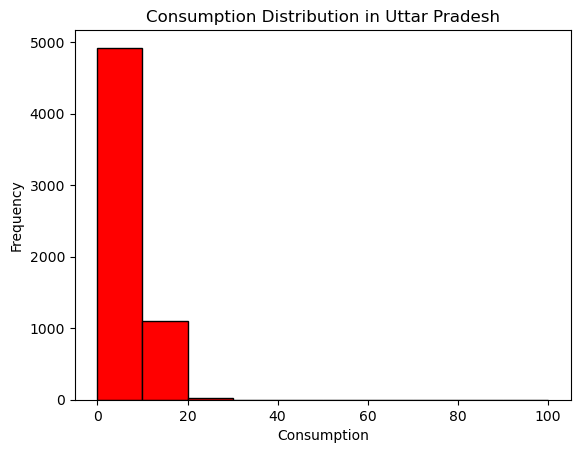

In [56]:
# Histogram
plt.hist(UPnew['total_consumption'], bins=10, color='red', edgecolor='black')
plt.xlabel("Consumption")
plt.ylabel("Frequency")
plt.title("Consumption Distribution in Uttar Pradesh")
plt.show()

In [57]:
UP_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   District           71 non-null     object 
 1   total_consumption  71 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In [72]:
UP_consumption['District'] = UP_consumption['District'].astype(str)
UP_consumption['total_consumption'] = UP_consumption['total_consumption'].astype(float)

In [67]:
UP_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   District           71 non-null     object 
 1   total_consumption  71 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

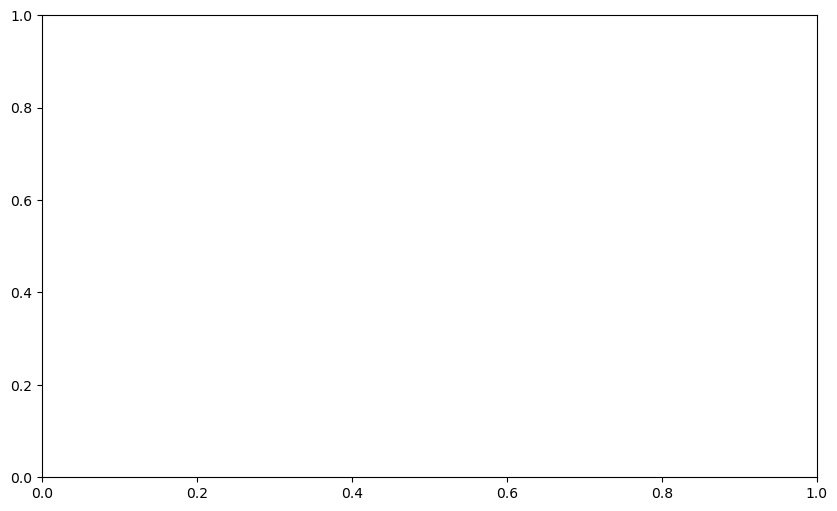

In [73]:
UP_consumption = UPnew.groupby('District')['total_consumption'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(UP_consumption['District'], UP_consumption['total_consumption'], color='blue', edgecolor='black')
plt.xlabel('District')
plt.ylabel('Total Consumption')
plt.title('Total Consumption per District')
plt.xticks(rotation=90)
plt.show()

In [44]:
data_map = gpd.read_file('C:\\Users\\SAMPREETH\\Downloads\\UTTAR PRADESH_DISTRICTS.geojson')

In [45]:
data_map = data_map.rename(columns={'dtname': 'District'})
data_map_data = data_map.merge(UP_consumption, on='District')

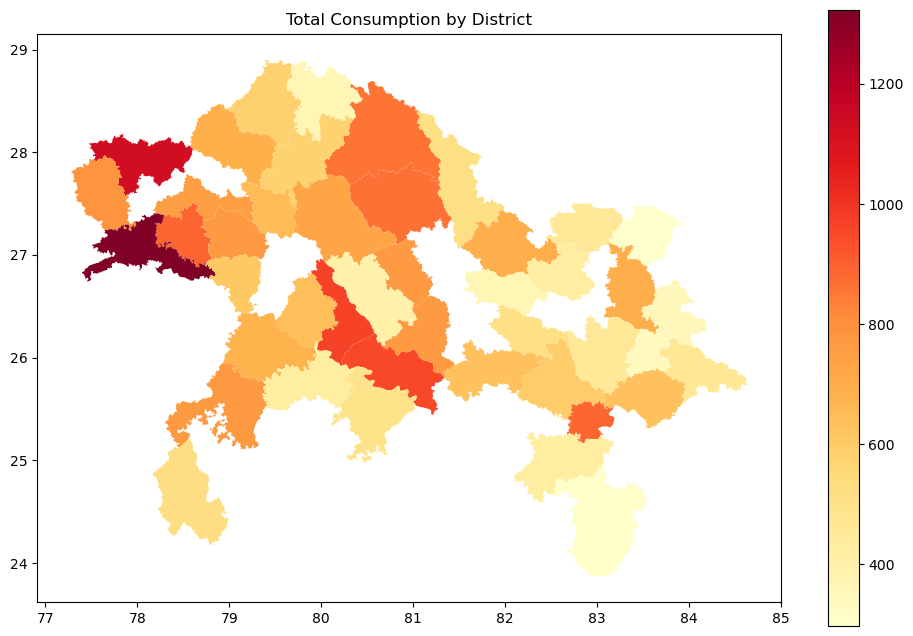

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
data_map_data.plot(column='total_consumption', ax=ax, legend=True, cmap='YlOrRd')
plt.title("Total Consumption by District")
plt.show()

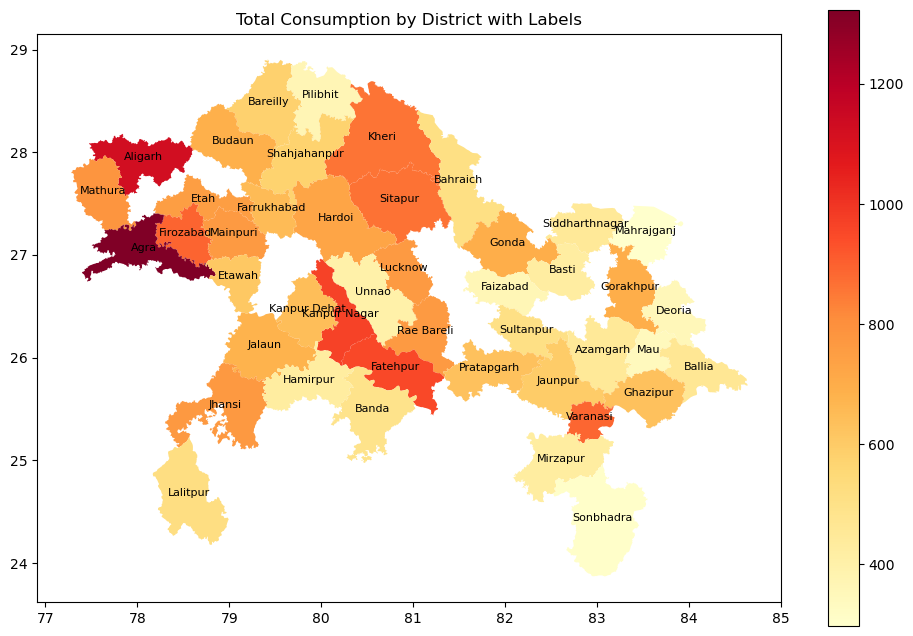

In [74]:
# Plot the map with district labels
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
data_map_data.plot(column='total_consumption', ax=ax, legend=True, cmap='YlOrRd')
data_map_data.apply(lambda x: ax.annotate(text=x.District, xy=x.geometry.centroid.coords[0], ha='center', fontsize=8), axis=1)
plt.title("Total Consumption by District with Labels")
plt.show()